# Project Topic
To receive full credit for this section, the learner should address the two questions below:
- Is there a clear explanation of what this project is about? 
- Does it give a clear description of generative deep learning models including Generative Adversarial Networks (GANs)?


This project is about generating music via deep learning. Specifically via LTSM (Long Term, Short Memory) Recurrent Neural Networks. The main goal is for my RNN to output and predict what note should come next. For instance, if it is given 4 notes, it should output the next note in the sequence based on the training data.

I used this excellent research paper as a reference https://people.idsia.ch/~juergen/blues/IDSIA-07-02.pdf which goes over musical compositions using LTSM RNNs.


# Data 
- Is there a clear description of the data, including the size, dimension, and structure? Some ideas for image data: you can include how many samples, number of channels (color or gray or more?) or modalities, image file format, whether images have the same dimension or not, etc.






The data we'll be using to generate our music are MIDI files. A MIDI file is a type of digital file used for storing music performance data. "MIDI" stands for Musical Instrument Digital Interface. It is a standardized format for communicating between musical devices like keyboards, synthesizers, or computers. Instead of containing actual sound recordings, MIDI files store instructions, like which notes to play, their timing, duration, and dynamics, as well as information about instrument types.

The data is from a free classical music site of famous composers.

External package requirements:
- ffmpeg
- fluidsynth
- lilypond
- musescore

In [24]:
import glob
import os
from collections import Counter

import IPython
import keras
import librosa
import matplotlib.pyplot as plt
import midi2audio
import numpy as np
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython.display import Audio, Image
from music21 import *
from pydub import AudioSegment
from sklearn.model_selection import train_test_split

# Using GPU to do training.
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
DATA_DIR = "data/"
EXPORT_DIR = "export/"

# Data size
I'll be using Beethoven's musical pieces which there are 29 of.

In [48]:
midi_paths = glob.glob(f"{DATA_DIR}composers/beeth/*.mid")
df_midi = pd.DataFrame(midi_paths, columns=["file_path"])
df_midi.describe()

,file_path
count,29
unique,29
top,data/composers/beeth/appass_1.mid
freq,1


Let's analyze how many instruments are in our MIDI files.

In [49]:
num_instruments = []
for file_path in df_midi["file_path"]:
    midi_file = pretty_midi.PrettyMIDI(file_path)
    num_instruments.append(len(midi_file.instruments))

df_midi["num_instruments"] = num_instruments
df_midi.describe()

,num_instruments
count,29.000000
mean,2.137931
std,0.441114
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,4.000000


They're all one, which is fine, we can generate something from this. Let's hear some samples of what the sound like. 

In [50]:
fs = midi2audio.FluidSynth(sound_font="default.sf2", sample_rate=22050)
def convert_midi_to_wav(midi_file_path, dest_file_path = "", force = False):
    """
    Convert a MIDI file to wav

    :param midi_file_path: File path of the midi file.
    :param dest_file_path: Path of the destination file. Don't include the file type
    :return: wav file path name
    """
    if dest_file_path == "":
        dest_file_path = f"{EXPORT_DIR}wav/{os.path.splitext(os.path.basename(midi_file_path))[0]}"

    export_file_path_wav = f"{dest_file_path}.wav"
    # Don't waste compute time on existing files
    if os.path.exists(export_file_path_wav) and not force:
        print("File exists.")
    else:
        # Converting MIDI to .wav.
        fs.midi_to_audio(midi_file_path, export_file_path_wav)
    return export_file_path_wav

Converting one of the the MIDI files to a wav so we can visualize some of the audio data.

In [55]:
sample_wav = convert_midi_to_wav(df_midi["file_path"][0])

File exists.


# Exploratory Data Analysis 
- EDA on images is open-ended, and it can be as simple as picking a few samples of images from each class, displaying them, and describing any findings. Some more ideas: you could plot histograms of those sample images and draw any conclusions. You could summarize image similarity by choosing a single metric to compare. The data may or may not have different image sizes, but you could mention that if the image sizes are different. Also, you can check how the range of the pixel intensities is distributed. You may also count labels (if multi-class or multi-label classification problem) to see if the labels are skewed, or you can plot a histogram of areas by segmentation labels, etc.
10 pts
- EDA goes above and beyond expectations: for example, in addition to picking a few sample images from each class, displaying them, and describing any findings, the learner includes several other histograms, appropriate visualizations, and detailed analysis of the dataset.





## Preprocessing


We want to grab all the notes from the midi files and see what it looks like

In [56]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

def display_musical_sheet(music):
    # requires lilypond package
    display(Image(str(music.write("lily.png"))))

# Playing the MIDI notes
def play_music(music):
    music.show('midi')

def get_melody_stream(musical_notes):
    all_notes = []
    offset = 0
    for i in musical_notes:
        # either a note or a chord.
        if ("." in i or i.isdigit()):
            # Break up all the notes that make up a chord
            chord_notes = i.split(".")
            notes = []
            for j in chord_notes:
                current_note = int(j)
                note_snip = note.Note(current_note)
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            all_notes.append(chord_snip)
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            all_notes.append(note_snip)
        offset += 1
    melody_stream = stream.Stream(all_notes)
    return melody_stream

Let's get all the chords from the MIDI files.

In [57]:
midi_chords = []
for path in midi_paths:
    chords = converter.parse(path)
    midi_chords.append(chords)

/home/basilp/.local/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/home/basilp/.local/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2008 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/home/basilp/.local/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2009 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/home/basilp/.local/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine i

We have all the chords now, let's extract all the notes from them and hear a small portion of it.

In [58]:
music_notes = extract_notes(midi_chords)
# a melody of the first 30 notes.
melody = get_melody_stream(music_notes[:30])

play_music(melody)

And a nice musical sheet display.

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmpoxc7apq8.ly'
Parsing...
Interpreting music...[8][8]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmpoxc7apq8.ly.eps'...
Converting to PNG...
Layout output to `tmpoxc7apq8.ly-1.eps'...
Writing tmpoxc7apq8.ly-systems.texi...
Writing tmpoxc7apq8.ly-systems.tex...
Writing tmpoxc7apq8.ly-systems.count...
Success: compilation successfully completed


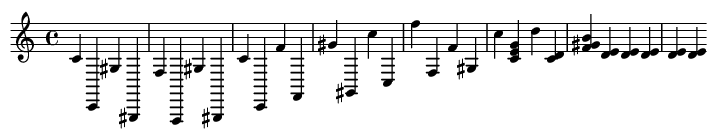

In [59]:
display_musical_sheet(melody)

How many unique notes do we have?

In [60]:
count_num = Counter(music_notes)
print("The total count of unique notes in the music:", len(count_num))

The total count of unique notes in the music: 349


Total notes and total unique notes

In [61]:
sorted_music_notes = sorted(list(set(music_notes)))
num_notes = len(music_notes)
unique_notes = len(sorted_music_notes)

print(f"Total number of notes: {num_notes}")
print(f"Total number of unique notes: {sorted_music_notes}")

Total number of notes: 81313
Total number of unique notes: ['0', '0.1', '0.1.2', '0.1.3', '0.1.3.5', '0.1.3.6.8', '0.1.4', '0.2', '0.2.3', '0.2.3.5', '0.2.4', '0.2.5', '0.2.5.8', '0.2.6', '0.2.7', '0.3', '0.3.5', '0.3.5.8', '0.3.6', '0.3.6.8', '0.3.6.9', '0.3.7', '0.4', '0.4.5', '0.4.6', '0.4.7', '0.4.8', '0.5', '0.6', '1', '1.2', '1.2.3', '1.2.4', '1.2.5.8', '1.3', '1.3.5.6', '1.3.5.7.8', '1.3.6', '1.3.6.8', '1.3.7', '1.3.8', '1.4', '1.4.6', '1.4.7', '1.4.7.10', '1.4.8', '1.5', '1.5.7', '1.5.8', '1.6', '1.7', '10', '10.0', '10.0.1', '10.0.1.3', '10.0.2', '10.0.3', '10.0.3.5', '10.0.3.6', '10.0.4', '10.0.5', '10.1', '10.1.3', '10.1.3.6', '10.1.4', '10.1.4.6', '10.1.5', '10.11', '10.11.3.6', '10.2', '10.2.3.5', '10.2.4', '10.2.5', '10.3', '11', '11.0', '11.0.1', '11.0.2', '11.0.2.5.7', '11.1', '11.1.2', '11.1.5', '11.2', '11.2.3', '11.2.4', '11.2.4.6', '11.2.5', '11.2.5.7', '11.2.6', '11.3', '11.3.5', '11.3.6', '11.4', '2', '2.3', '2.3.4', '2.3.5', '2.3.5.7.8', '2.3.5.8.10', '2.3.7', '2

Frequency of notes and the average recurrence which is the repetition of notes.

In [62]:
notes = list(count_num.keys())
recurrence = list(count_num.values())
print(f"Average recurrence for a note in music: {sum(recurrence) / len(recurrence):0.2f}")
print(f"Most frequent note in music appeared: {max(recurrence)} times")
print(f"Least frequent note in music appeared: {min(recurrence)} time")

Average recurrence for a note in music: 232.99
Most frequent note in music appeared: 2094 times
Least frequent note in music appeared: 1 time


How about all the rare notes?

In [63]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print(f"Total number of notes that occur less than 100 times: {len(rare_note)}")

Total number of notes that occur less than 100 times: 215


In [64]:
for element in music_notes:
    if element in rare_note:
        music_notes.remove(element)

print(f"Length of notes after removing the rare notes: {len(music_notes)}")

Length of notes after removing the rare notes: 77565


# Visualizations

- Waveform
    - Displays amplitude over time
- Spectrogram
    - Display a frequency-based over time
- Mel Spectrogram
    - Display human perception of frequency based on the mel scale
- Chromagram
    - Displays intensity of pitch over time (harmony and melody)

In [65]:
def display_waveform(file_path):
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def display_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

def display_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

def display_chromagram(file_path):
    y, sr = librosa.load(file_path)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title('Chromagram')
    plt.show()

def display_all_graphs(file_path):
    display_waveform(file_path)
    display_spectrogram(file_path)
    display_mel_spectrogram(file_path)
    display_chromagram(file_path)

We can see from the graphs below with out example audio sample of the amplitude and frequencies. We also see the frequencies of our audio tend to be around 0-6000 in frequency while anything higher is unhearable.

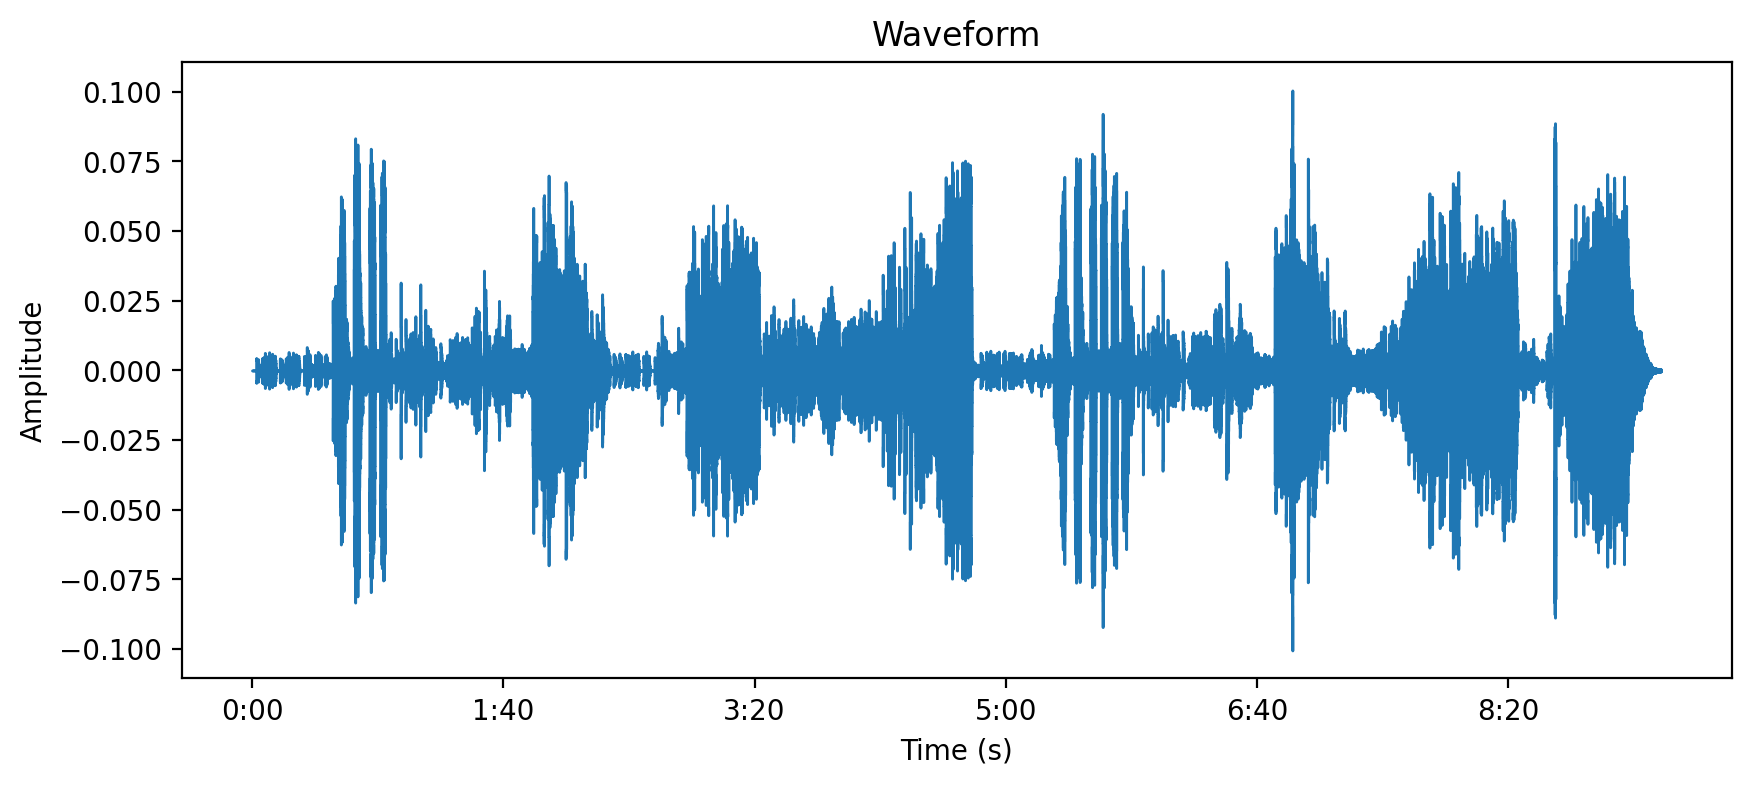

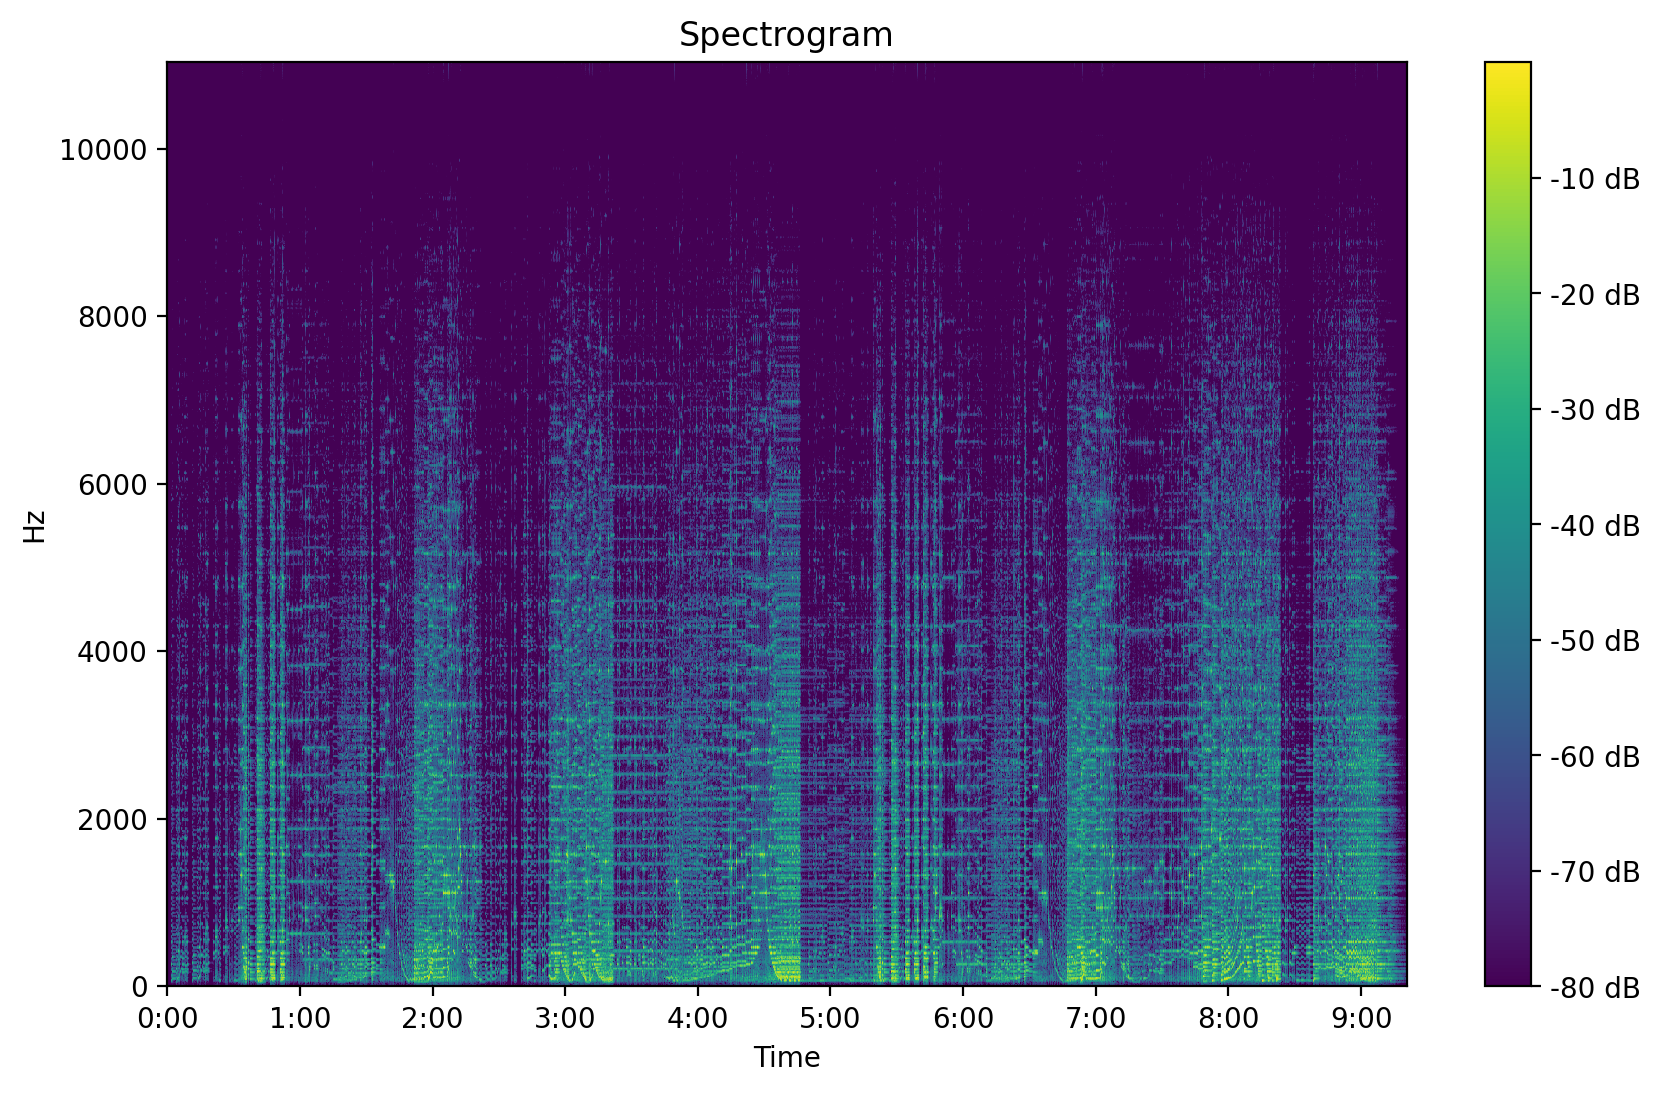

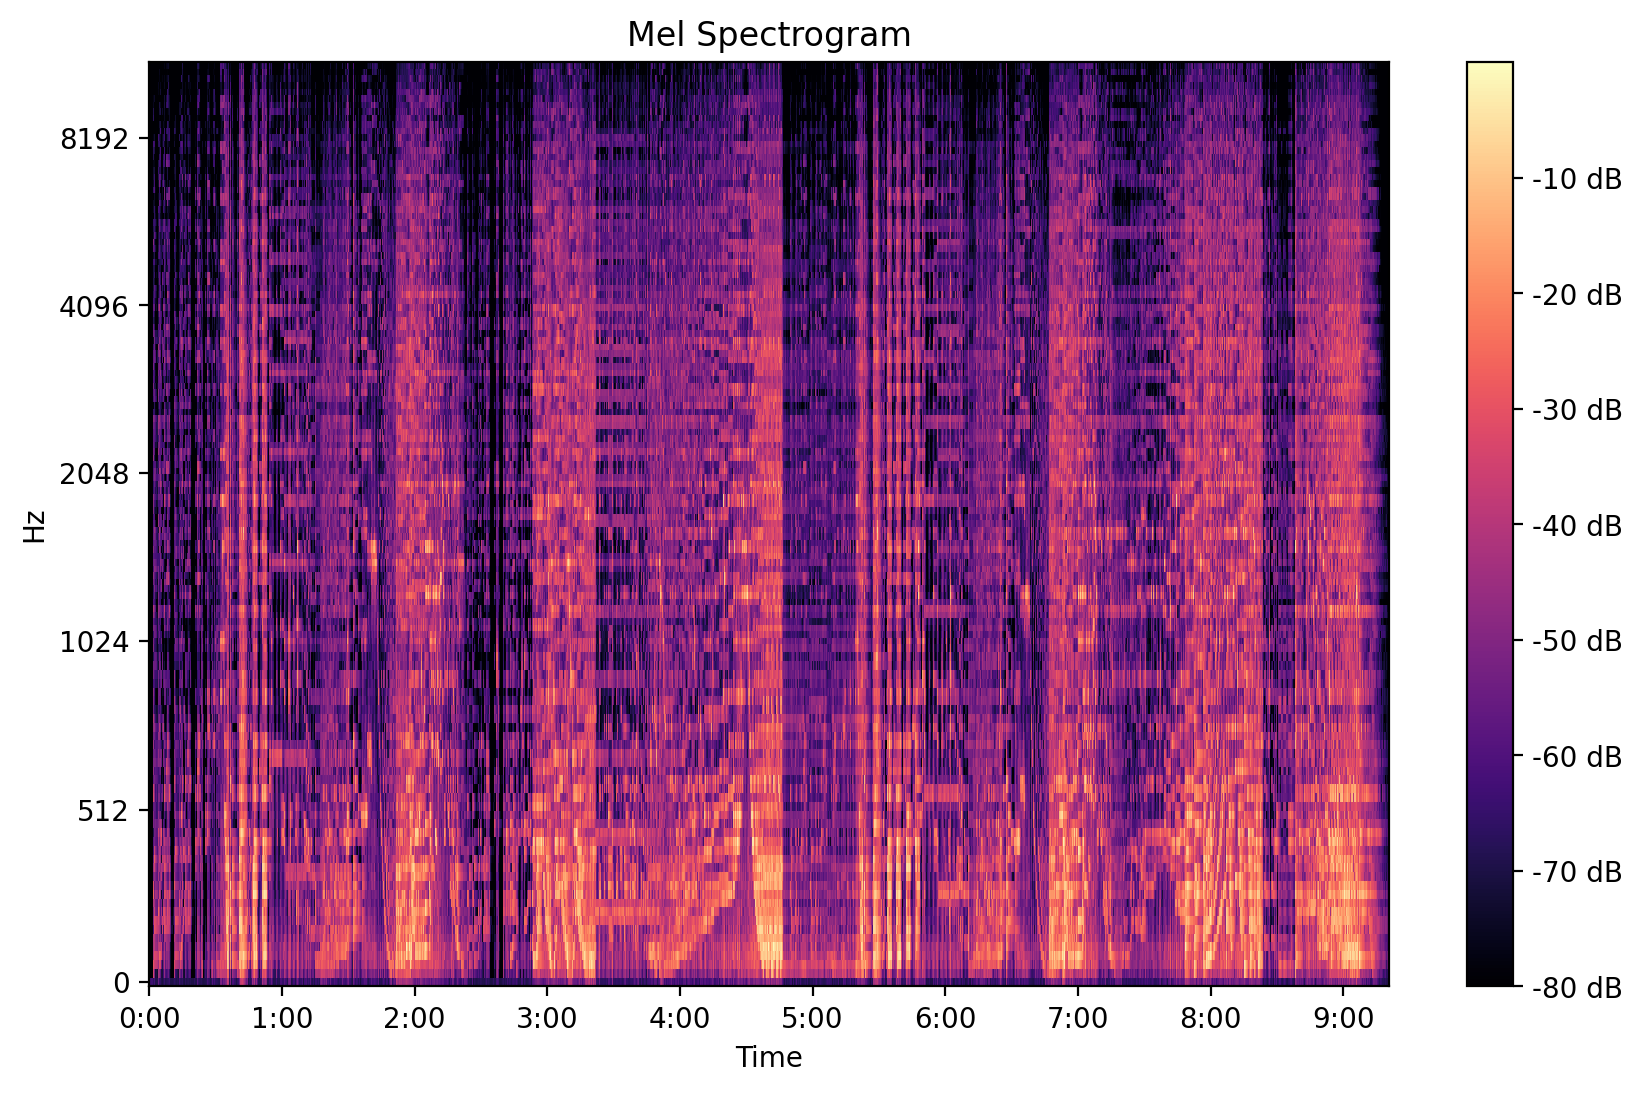

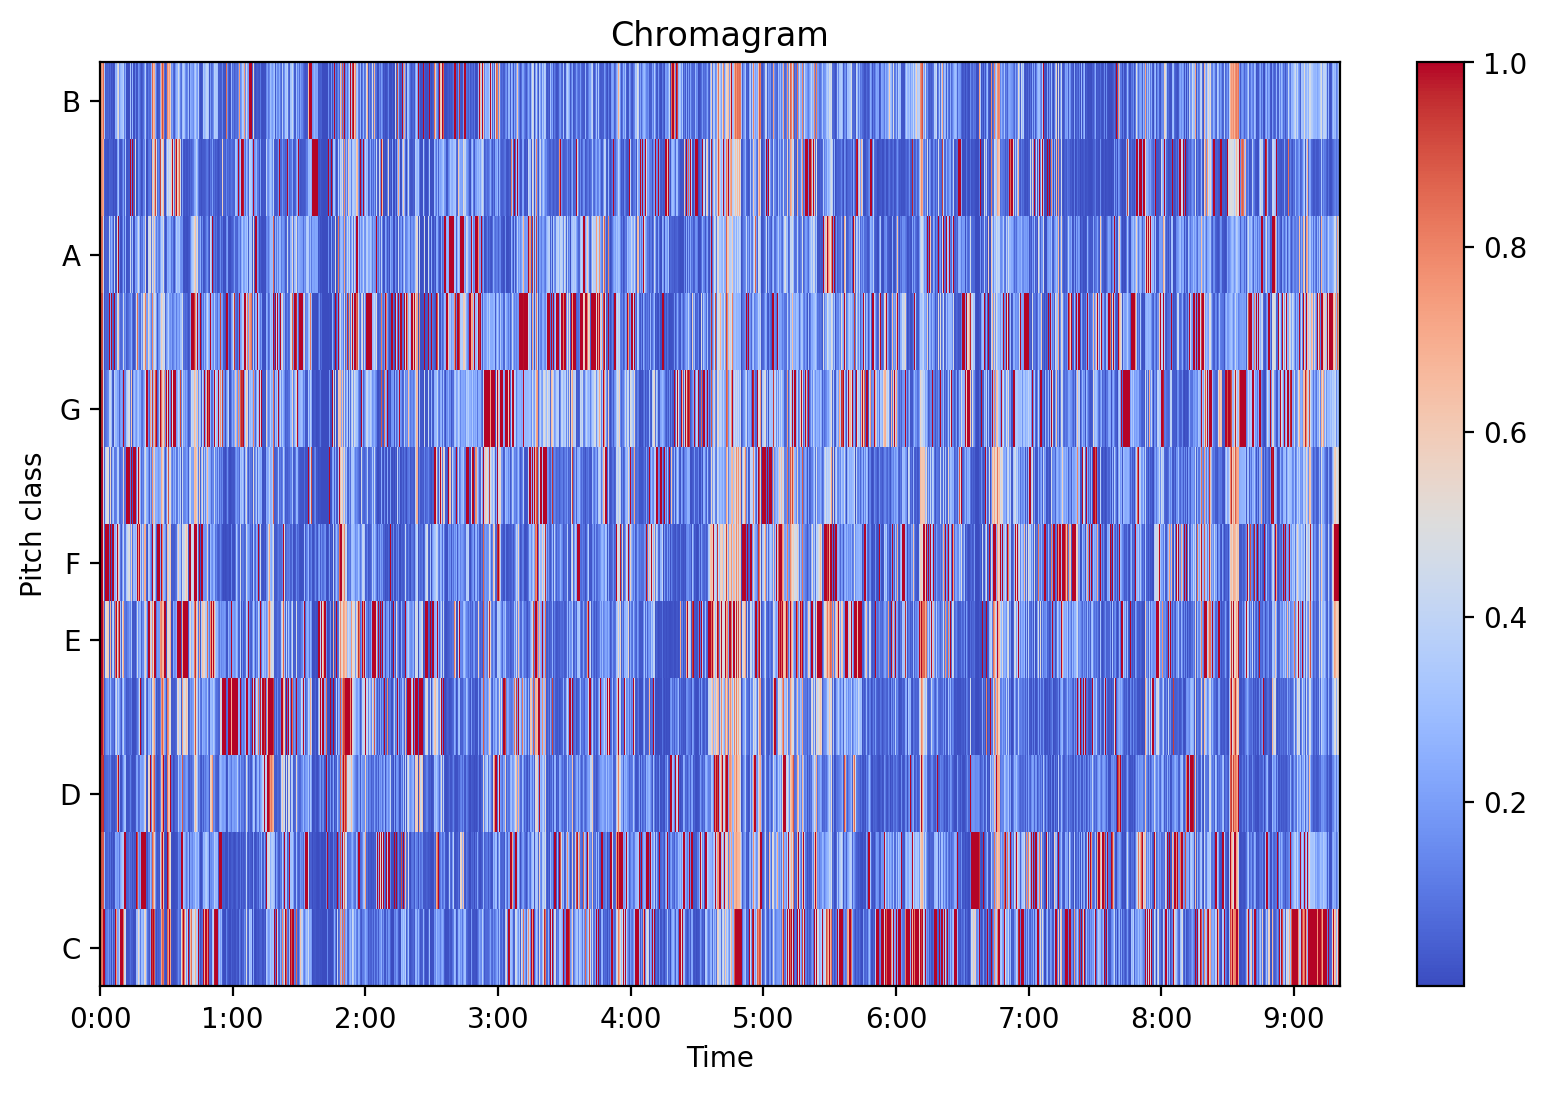

In [67]:
display_all_graphs(sample_wav)


# Model Architecture
- Does it describe the model architecture and explain why the learner believes a specific architecture/loss function is suitable for the problem? 
- Did the learner tune the hyperparameters? 
- Did the learner compare multiple architectures/loss functions?
- Note, when you evaluate, don't just base your score on the complexity of the model/technique or performance of the model alone. Base your score on how the learner demonstrates understanding by explaining the concepts and why they chose particular methods/techniques.



The model architecture I chose was Long Short-Term Memory Recurrent Neural Networks or LSTM RNNs for short. They are a type of deep learning model designed to process and analyze sequential data. Unlike traditional RNNs (Recurrent Neural Networks), LSTMs excel at handling long-term dependencies in sequences. This is achieved by their unique structure, which includes specialized components—called gates—that regulate the flow of information and selectively remember or forget parts of the input data. This design addresses the problem of vanishing gradients in traditional RNNs, allowing LSTMs to better retain and utilize relevant information over longer sequences.

How they can be used to generate music:
LSTM RNNs can be applied to music generation by learning patterns and structures within existing musical compositions. Here's an overview of how this works:

Training Phase: The LSTM is fed sequences of notes or musical data (e.g., MIDI files) and trained to predict the next note or sequence based on the given input. It learns musical structures, harmonies, rhythms, and dynamics over time.

Generation Phase: Once trained, the LSTM can generate new music by providing it with a starting sequence, or "seed." The model predicts subsequent notes or musical elements, creating an original composition while maintaining coherence and flow.

Applications: LSTM-generated music can be used in various creative contexts—video game soundtracks, background music for films, personalized compositions, or even experimental genres.

We start by building a dictionary that maps each unique note in the corpus to a corresponding index. Since note names are symbolic representations for the computer, this dictionary allows us to associate each note with a numerical value. This mapping is essential for both encoding the input and decoding the output during the operations of the RNN.

In [79]:
mapping = dict((c, i) for i, c in enumerate(sorted_music_notes))
reverse_mapping = dict((i, c) for i, c in enumerate(sorted_music_notes))

Next, the notes in the `music_notes` are encoded and split into smaller sequences of fixed lengths. These sequences form the input features and corresponding targets, with each note represented by its mapped index from the dictionary. This structured format enables the RNN to learn patterns effectively.

In [ ]:
music_notes = extract_notes(midi_chords)

length = 40
features = []
targets = []
for i in range(0, num_notes - length, 1):
    feature = music_notes[i:i + length]
    target = music_notes[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


sequences = len(targets)
print("Total number of sequences in the music:", sequences)

Total number of sequences in the music: 81273


After encoding, we designate the input features as X and the targets as y. The input data is resized and normalized, while the targets are transformed using one-hot encoding. With the data prepared, it’s ready to be fed into the RNN for training. But before training, the RNN model itself must first be constructed.

In [70]:
# reshape X and normalize
X = (np.reshape(features, (sequences, length, 1)))/ float(unique_notes)
# one hot encode the output variable
y = tf.keras.utils.to_categorical(targets)

To generate music, a portion of the dataset is reserved as a seed for the RNN. While we could train on the entire dataset, setting aside a segment as a seed avoids the need to manually generate an input seed. This reserved data acts as the starting point for the music generation process.

In [ ]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dense(256))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(y.shape[1], activation='softmax'))
opt = keras.optimizers.Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

/home/basilp/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 40, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 349)            │        89,693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,995,613 (7.61 MB)

 Trainable params: 1,995,613 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - loss: 4.9834
Epoch 2/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 82s 321ms/step - loss: 4.7945
Epoch 3/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 137s 540ms/step - loss: 4.7880
Epoch 4/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 126s 495ms/step - loss: 4.7835
Epoch 5/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 156s 615ms/step - loss: 4.7821
Epoch 6/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 98s 389ms/step - loss: 4.7671
Epoch 7/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 89s 351ms/step - loss: 4.7781
Epoch 8/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 60s 237ms/step - loss: 4.7747
Epoch 9/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 115s 454ms/step - loss: 4.7736
Epoch 10/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 56s 222ms/step - loss: 4.7648
Epoch 11/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 85s 334ms/step - loss: 4.7659
Epoch 12/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 112s 441ms/step - loss: 4.7669
Epoch 13/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 88s 347ms/step - loss: 4.7651
Epoch 14/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 82s 325ms/step - loss: 4.766

# Epochs Hyperparameter Tuning

Roughly 75 epochs is what we need to achieve a good loss ratio.

[Text(0.5, 0, 'Epochs')]

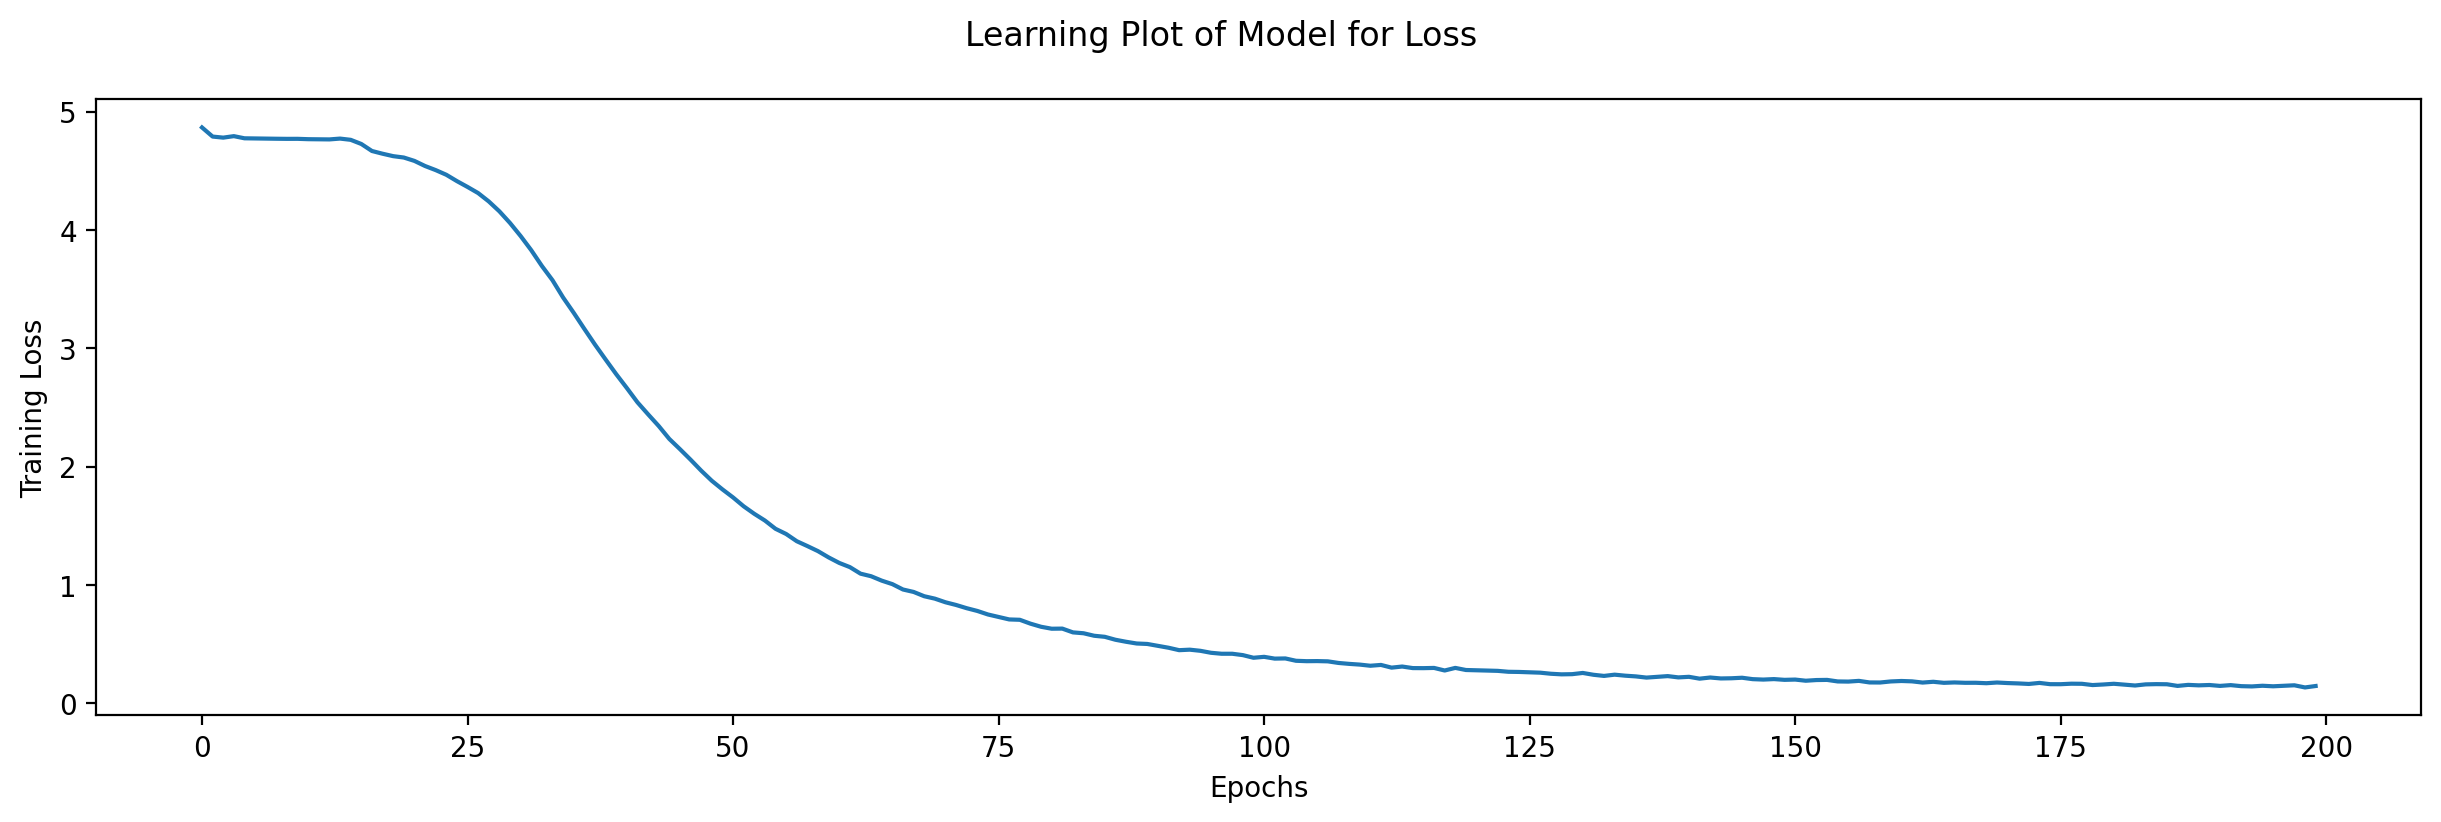

In [75]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [76]:
def music_generator(notes_to_generate):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    music = ""
    notes_generated=[]
    for i in range(notes_to_generate):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        # diversity of notes
        prediction = np.log(prediction) / 1.0
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        index = np.argmax(prediction)
        index_N = index/ float(unique_notes)
        notes_generated.append(index)

        music = [reverse_mapping[char] for char in notes_generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    melody = get_melody_stream(music)
    melody_stream = stream.Stream(melody)
    return music, melody_stream


/tmp/ipykernel_491136/3152253507.py:9: RuntimeWarning: divide by zero encountered in log
  prediction = np.log(prediction) / 1.0
Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmpbtouj0ym.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmpbtouj0ym.ly.eps'...
Converting to PNG...
Layout output to `tmpbtouj0ym.ly-1.eps'...
Layout output to `tmpbtouj0ym.ly-2.eps'...
Layout output to `tmpbtouj0ym.ly-3.eps'...
Writing tmpbtouj0ym.ly-systems.texi...
Writing tmpbtouj0ym.ly-systems.tex...
Writing tmpbtouj0ym.ly-systems.count...
Success: compilation successfully completed


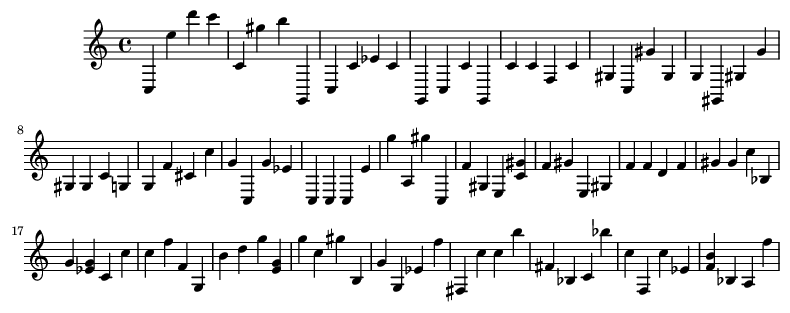

In [77]:
generated_music, music_stream = music_generator(100)
display_musical_sheet(music_stream)

In [78]:
play_music(music_stream)

In [ ]:
model.fit(X_train, y_train, batch_size=256, epochs=75)

Epoch 1/75
254/254 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - loss: 0.1182
Epoch 2/75
100/254 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - loss: 0.1117

# Results and Analysis


# Conclusion 
Does the conclusion include the following:
- Basic reiteration of results
- Discussion of learning and takeaways
- Discussion of why something didn’t work.
- Suggestions for ways to improve.